<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/D2L_Lab_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Deep Learning for MSc - Lab Coding Task 2025

## Key Tasks

1. Ensure you have done the prerequisites preliminary work given above.
2. Slowly run the notebook cells while you read the notebook cell descriptions and code. Make sure you understand how the code is working and the structure of the framework.
3. Modify the code to generate / synthesize appropriate data as given in Lab 2, Task 1. (Including changing the code to use the same probability distributions as Lab 2 / Task 1.)
4. Modify the code to use the more complicated model given in Lab 2, Task 1. (Hint: Look at D2L Book Chapter 5 to see how this could be done.)
5. **You should modify the template to make your data synthesis, neural network architecture and optimization approach as close to the original Task 1 Lab 2 as possible except: generate 500 training points and 500 validation points, use a batch size of 100 and run 100 epochs.**
6. Look at the results and resolve any issues that might be present. (Some aspects of this task require problem solving and you will need to solve any issues that may arise - potentially including coding issues with this original template code!)
7. Ensure that you have "clean code" and "notebook documentation" - you should remove anything that is not relevant to the new model - and you should update Markdown documentation to reflect how the new code works.
8. **IMPORTANT - You should not change the plotting code !**
9. Upload the notebook of your solution to Moodle.

Good Luck !



# Synthetic Regression Data


In [1]:
%matplotlib inline

# !pip install torch==2.0.0
# !pip install torchvision==0.15.1
# !pip install d2l==1.0.3

import random
import torch
from torch import nn

from d2l import torch as d2l

## Generating the Dataset


In [2]:
import math
import numpy as np

class SyntheticRegressionData(d2l.DataModule):  # @save
    """Synthetic data for nonlinear regression based on the given function."""
    def __init__(self, noise=0.1, num_train=500, num_val=500, batch_size=100):
        super().__init__()
        self.save_hyperparameters()

        n = num_train + num_val
        self.X = torch.rand(n, 1) - 0.5
        epsilon = torch.randn(n, 1) * noise
        self.y = self.ground_truth_function(self.X) + epsilon

    def ground_truth_function(self, x):
        return -torch.sin(10 * math.pi * (x + 0.5) * torch.sin(x ** 3))


In [3]:
data = SyntheticRegressionData(noise=0.1)

In [4]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([-0.0442]) 
label: tensor([0.1080])


## Reading the Dataset


In [5]:
# We will use the concise implementation of the data loader given below.

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [6]:
# Fetch a batch of training data
X, y = next(iter(data.get_dataloader(train=True)))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([100, 1]) 
y shape: torch.Size([100, 1])


In [7]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [8]:
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

The new data loader behaves just like the previous one, except that it is more efficient and has some added functionality.


In [9]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([100, 1]) 
y shape: torch.Size([100, 1])


In [10]:
len(data.train_dataloader())

5

## Defining the Model
Model consists of 2 layers with 10 neurons in each. Activation function used is ReLU. Loss function is Mean Squared Error (MSE) and optimization is done with Stochastic Gradient Descent (SGD).


In [11]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):

      super().__init__()
      self.save_hyperparameters()
      # self.net = nn.LazyLinear(1)
      # self.net.weight.data.normal_(0, 0.01)
      # self.net.bias.data.fill_(0)
      Nhidden=10
      self.fc1 = nn.Linear(1, Nhidden)
      self.fc2 = nn.Linear(Nhidden, 1)

In [12]:
import torch.nn.functional as F

@d2l.add_to_class(LinearRegression)  #@save
def forward(self, x):
    x = F.relu(self.fc1(x))  # tanh() or sigmoid()
    # x = F.tanh(self.fc2(x))
    x = self.fc2(x)
    return x

## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.


In [13]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.


In [14]:
import torch.optim as optim

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)

## Training

**THE FOLLOWING FOUR LINES ARE KEY TO THE FRAMEWORK - MODEL OBJECT, DATA OBJECT, TRAINING OBJECT and then TRAIN.**


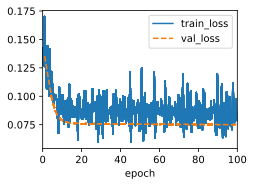

In [15]:
model = LinearRegression(lr=0.01)
data = SyntheticRegressionData(noise=0.1)
trainer = d2l.Trainer(max_epochs=100)
trainer.fit(model, data)

In [16]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
  return (self.fc1.weight.data, self.fc1.bias.data, self.fc2.weight.data, self.fc2.bias.data)

w1, b1, w2, b2 = model.get_w_b()

w1, b1, w2, b2

(tensor([[ 0.9185],
         [-0.2307],
         [-0.2624],
         [-0.2034],
         [-0.1269],
         [-0.0208],
         [ 0.6231],
         [ 0.4163],
         [-0.9209],
         [ 0.2766]]),
 tensor([ 0.9906, -0.9997,  0.9742, -0.4806, -0.6782, -0.7678,  0.3444, -0.8152,
          0.3227,  0.5575]),
 tensor([[-0.4643, -0.2764,  0.0972, -0.0102, -0.2239,  0.2946,  0.0464,  0.2221,
           0.3941, -0.1985]]),
 tensor([0.2312]))

In [17]:
print(f'Weights of fc1:\n{w1}')
print(f'Bias of fc1:\n{b1}')
print(f'Weights of fc2:\n{w2}')
print(f'Bias of fc2:\n{b2}')

Weights of fc1:
tensor([[ 0.9185],
        [-0.2307],
        [-0.2624],
        [-0.2034],
        [-0.1269],
        [-0.0208],
        [ 0.6231],
        [ 0.4163],
        [-0.9209],
        [ 0.2766]])
Bias of fc1:
tensor([ 0.9906, -0.9997,  0.9742, -0.4806, -0.6782, -0.7678,  0.3444, -0.8152,
         0.3227,  0.5575])
Weights of fc2:
tensor([[-0.4643, -0.2764,  0.0972, -0.0102, -0.2239,  0.2946,  0.0464,  0.2221,
          0.3941, -0.1985]])
Bias of fc2:
tensor([0.2312])


# Plot sample data, theoretical function and the fitted model function. #

********** **DO NOT MODIFY THE CODE BELOW !** **********


Text(0, 0.5, '$y$')

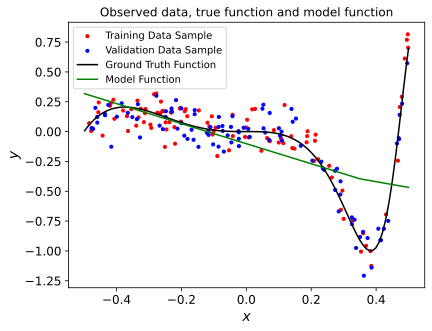

In [18]:

# ********** DO NOT MODIFY THIS CODE ********** #

# ********** IT SHOULD WORK WITHOUT CHANGING THIS CODE ********** #

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

X = data.X.squeeze(1)
y = data.y.squeeze(1)

xgrid = torch.linspace(torch.min(X),torch.max(X),100)

fig = plt.figure()
plt.scatter(X[0:100],y[0:100],10,'r')
plt.scatter(X[100:200],y[100:200],10,'b')

plt.plot(xgrid,data.ground_truth_function(xgrid),'k')
plt.plot(xgrid,model(xgrid.unsqueeze(1)).detach(),'g')

plt.title('Observed data, true function and model function')
plt.legend(['Training Data Sample','Validation Data Sample', 'Ground Truth Function','Model Function'])
plt.xlabel('$x$')
plt.ylabel('$y$')
